# Preprocess of the video

In [2]:
!pip install opencv-python

In [3]:
!pip install torch

In [4]:
!pip install torchvision

In [1]:
# importing libraries
import cv2 # video to frame
import torch # tensors
from torchvision import transforms # preprocessing
import numpy as np # arrays
import os # directory work

In [23]:
# function for extracing, preprocessing, and saving video frames
def preprocess(fileName, extractedFrames):
    cap = cv2.VideoCapture(fileName)
    frameCount = 0
    frames = []
    # calculates how many frames to skip
    totalFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skipFactor = int(totalFrames / extractedFrames)
    # extracts frames till none left
    while cap.isOpened:
        ret, frame = cap.read()
        if not ret:
            break
        frameCount += 1
        # skips frames
        if frameCount % skipFactor != 0:
            continue
        # correcting color mode
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # resizing /scaling
        frame = cv2.resize(frame, (128, 128))
        # normalizing
        frame = frame / 255
        # adding frame to list
        frames.append(frame)
    # saves array in npy file
    frames = np.array(frames)
    np.save(fileName.split(".")[0] + ".npy", frames)

In [2]:
# gets all mp4 files from current directory
files = [file for file in os.listdir(os.getcwd()) if file.endswith(".mp4")]

In [26]:
for file in files:
    preprocess(file, 5)

# Embedding model

In [27]:
!pip install keras

In [28]:
!pip install tensorflow

In [3]:
# gets all npy files from current directory
files = [file for file in os.listdir(os.getcwd()) if file.endswith(".npy")]
# loads all arrays from files
arr = [np.load(file) for file in files]
# creates array of frames for input
frames = np.array([frame for sublist in arr for frame in sublist])

Followed https://blog.keras.io/building-autoencoders-in-keras.html to develop autoencoder

In [4]:
# importing classes
import keras
from keras import layers
from sklearn.model_selection import train_test_split

In [5]:
# input layer
input_img = layers.Input(shape=(128, 128, 3))
# encoder
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x =layers. MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
# decoder
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
# autoencoder
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [6]:
# setting variables
batch_size = 50
# splitting into training/testing data
x_train, x_test = train_test_split(frames, test_size=0.2)
# training
autoencoder.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test, x_test),
    verbose=1
)

Epoch 1/50
4/4 [==============================] - 7s 1s/step - loss: 0.0726 - val_loss: 0.0686
Epoch 2/50
4/4 [==============================] - 5s 1s/step - loss: 0.0655 - val_loss: 0.0613
Epoch 3/50
4/4 [==============================] - 4s 1s/step - loss: 0.0552 - val_loss: 0.0526
Epoch 4/50
4/4 [==============================] - 4s 1s/step - loss: 0.0453 - val_loss: 0.0410
Epoch 5/50
4/4 [==============================] - 4s 1s/step - loss: 0.0402 - val_loss: 0.0405
Epoch 6/50
4/4 [==============================] - 4s 1s/step - loss: 0.0353 - val_loss: 0.0369
Epoch 7/50
4/4 [==============================] - 4s 1s/step - loss: 0.0327 - val_loss: 0.0335
Epoch 8/50
4/4 [==============================] - 4s 1s/step - loss: 0.0295 - val_loss: 0.0317
Epoch 9/50
4/4 [==============================] - 4s 1s/step - loss: 0.0261 - val_loss: 0.0266
Epoch 10/50
4/4 [==============================] - 4s 1s/step - loss: 0.0234 - val_loss: 0.0247
Epoch 11/50
4/4 [==============================] 

In [7]:
# storing autoencoded embeddings
batch_predictions = []
for i in range(0,len(frames),batch_size):
    print(i)
    batch_predictions.append(autoencoder.predict(frames[i:i+batch_size]))

0
2/2 [==============================] - 0s 78ms/step
50
2/2 [==============================] - 0s 72ms/step
100
2/2 [==============================] - 0s 82ms/step
150
2/2 [==============================] - 0s 75ms/step
200
2/2 [==============================] - 0s 72ms/step


In [8]:
# unpacking predicted embeddings
embeddings = []
for batch in batch_predictions:
    for pred in batch:
        embeddings.append(pred)

At this point, we have our pairs (image, corresponding vector embeddings). They are stored in frames and embeddings respectively. I did not store them on GitHub LFS due to annoucnement by the professor entitled "GitHub LFS - Nov 2023 update."

# Combination

A simple way to aggregate the video embeddings is to average out their values. I will average out the values between each video's embeddings, storing this into a new array.

In [9]:
aggregated_embeddings = []
for i in range(0, len(embeddings), 5):
    stacked_arrays = np.stack([embeddings[i],embeddings[i+1],embeddings[i+2],embeddings[i+3],embeddings[i+4]])
    aggregated_embeddings.append(np.mean((stacked_arrays), axis=0))

In [10]:
print(len(aggregated_embeddings))

50


# Indexing

Followed this tutorial https://www.youtube.com/watch?v=qECVC6t_2mU, changing image property to akane/pgvector.

After setting up my PostgreSQL database and PGAdmin, I ran the following queries in PGAdmin to set up my database:
CREATE EXTENSION vector;
CREATE TABLE embeddings (
	id SERIAL PRIMARY KEY,
	name VARCHAR(255),
	embedding vector(10752)
);

In [11]:
# creating names for embeddings
names = []
for file in files:
    for i in range(1, 6):
        names.append(file + "-" + str(i))    

In [21]:
# flattening embeddings
flattened_embeddings = []
for e in embeddings:
    flattened_embeddings.append(e.ravel()[:16000])

In [95]:
!pip install psycopg2

   ---------------------------------------- 1.2/1.2 MB 3.9 MB/s eta 0:00:00


In [13]:
# importing libaries
import psycopg2
from psycopg2 import extras

In [28]:
# connecting to db
connection = psycopg2.connect (
    host = "localhost",
    port = "5432",
    database = "youtube_video_search",
    user = "root",
    password = "root"
)
if connection.closed == 0:
    print("Connection established")

Connection established


In [29]:
cursor = connection.cursor()

In [30]:
# inserting embeddings
for i in range(len(names)):
    cursor.execute("INSERT INTO embeddings (name, embedding) VALUES (%s, %s)", (names[i], flattened_embeddings[i].tolist()))
    connection.commit()

In the following image, I'm querying the database using an image and its corresponding embedding. This query is outputting the 10 images with embeddings that are most similar to the input image. Specifically, I am using cosine similarity for my vector similarity search.
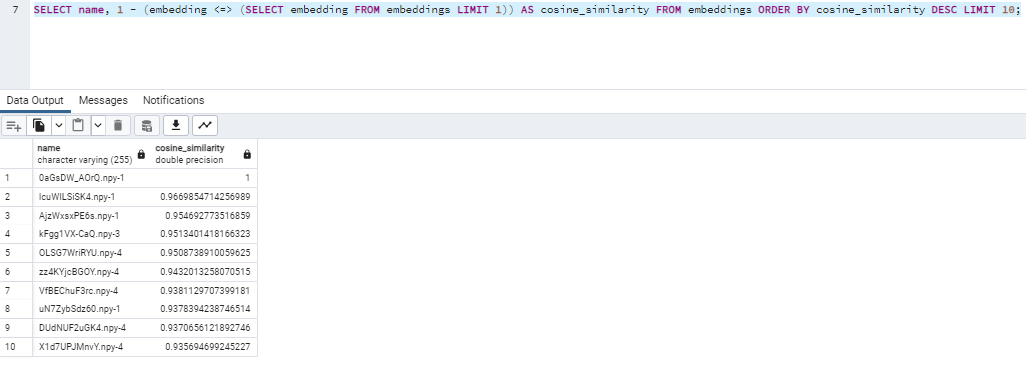

This is the query image:
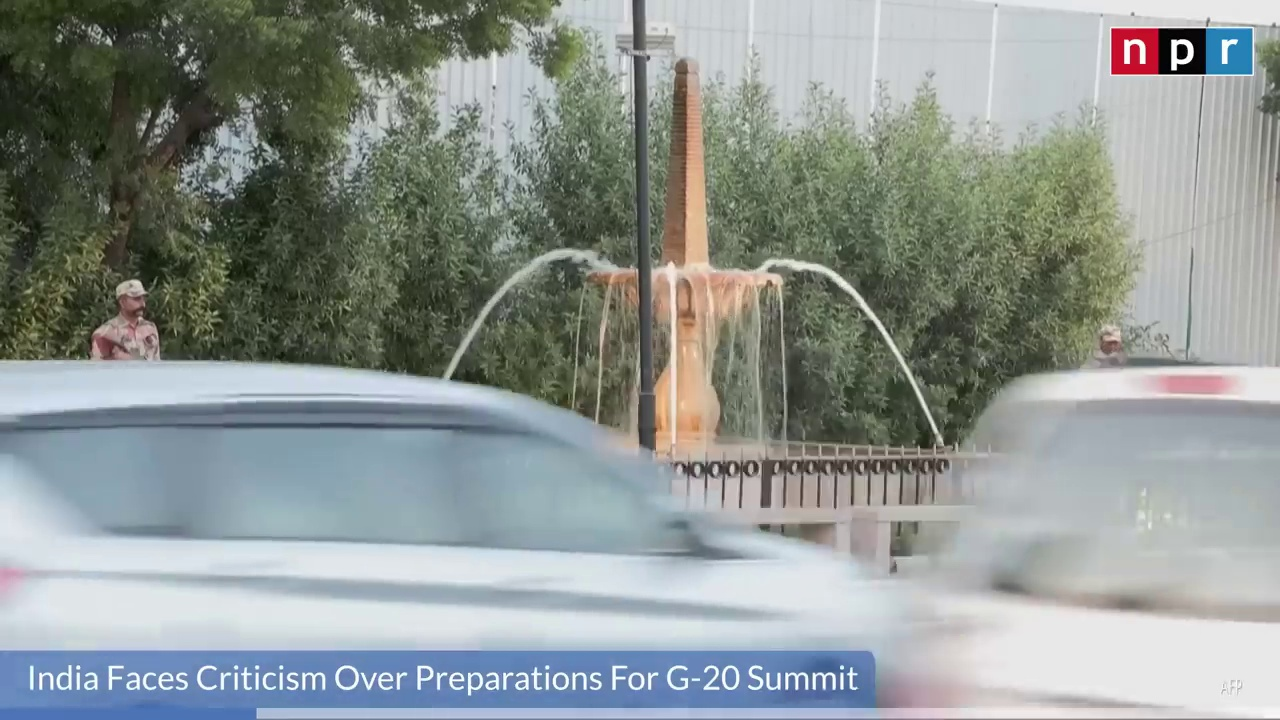
The following are the images that were most similar:
1. 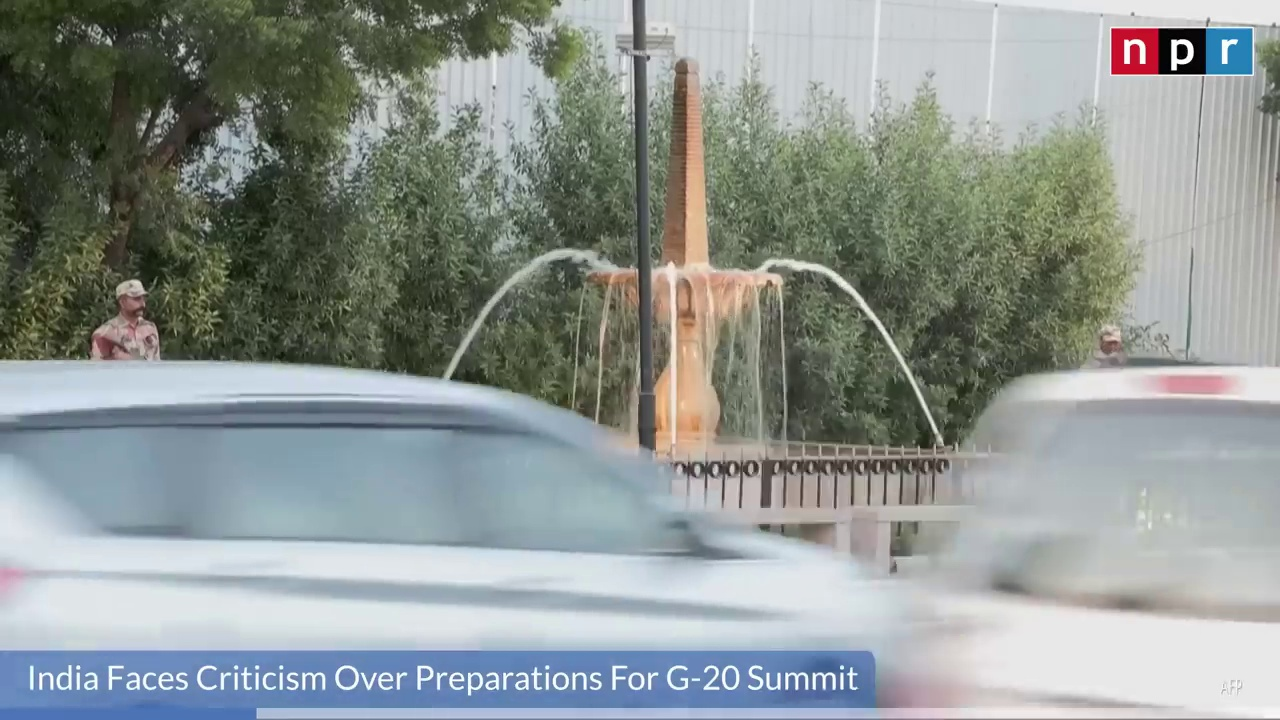

2. 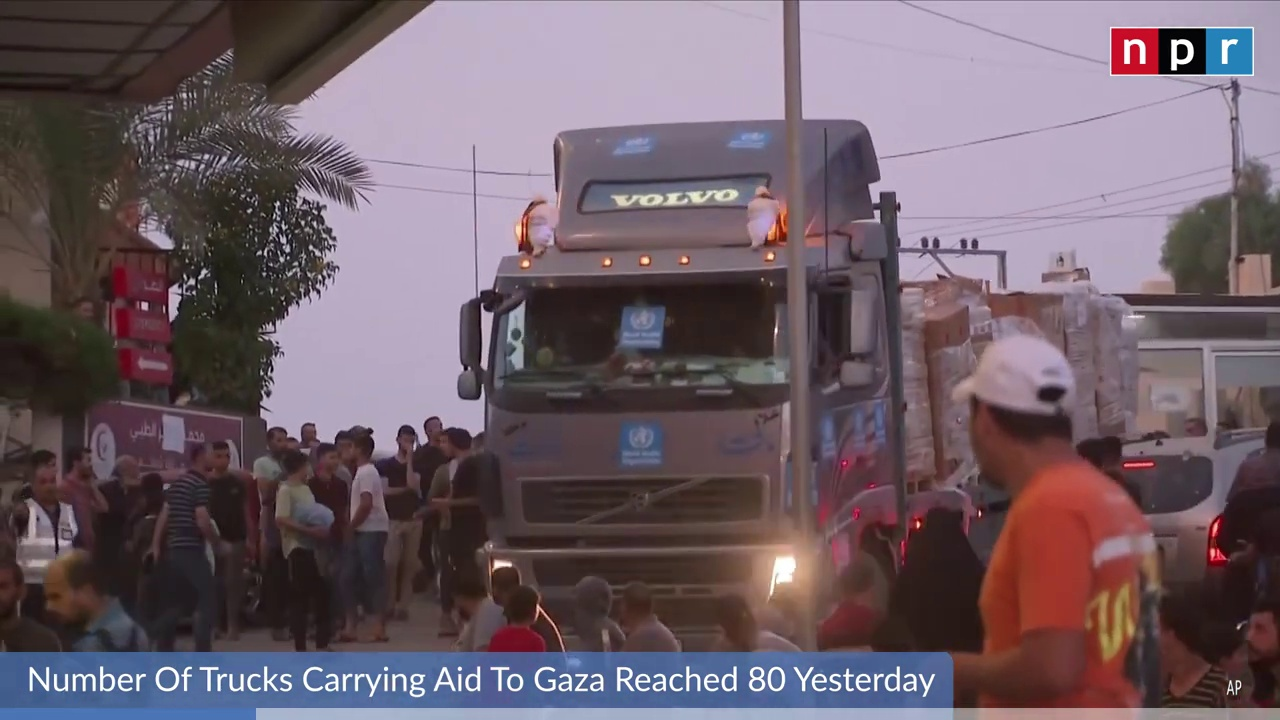

3. 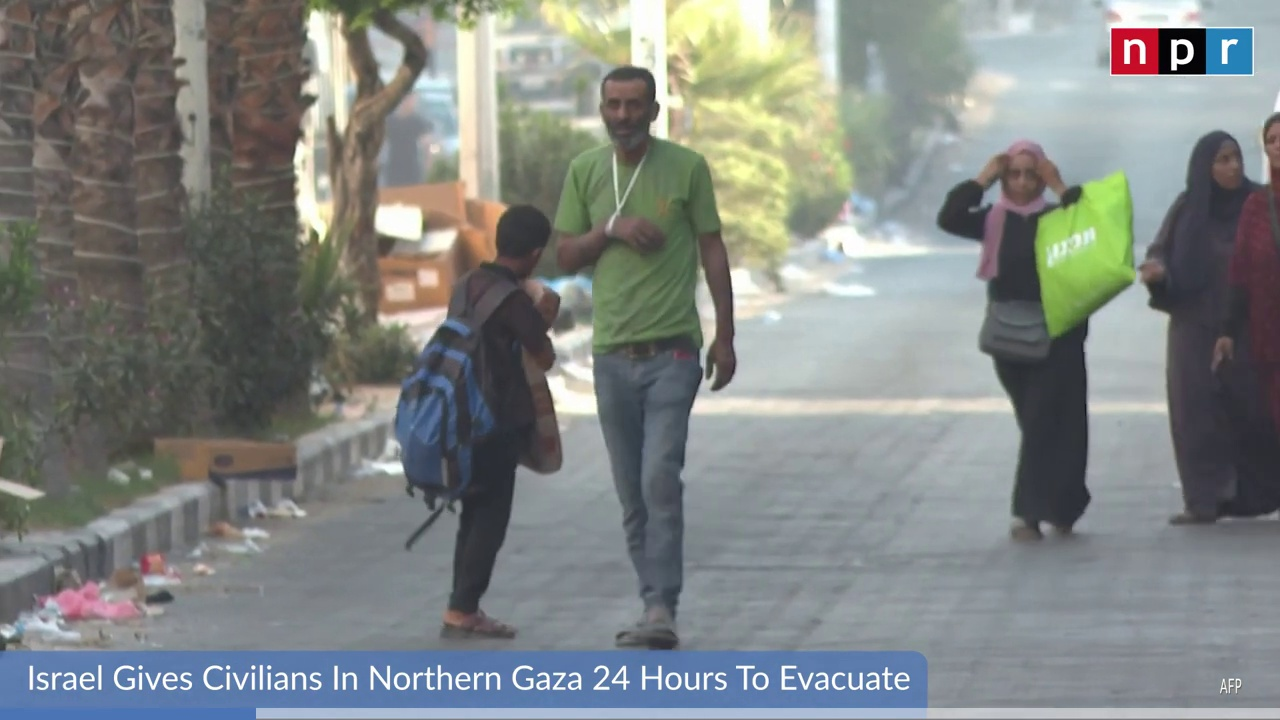

4. 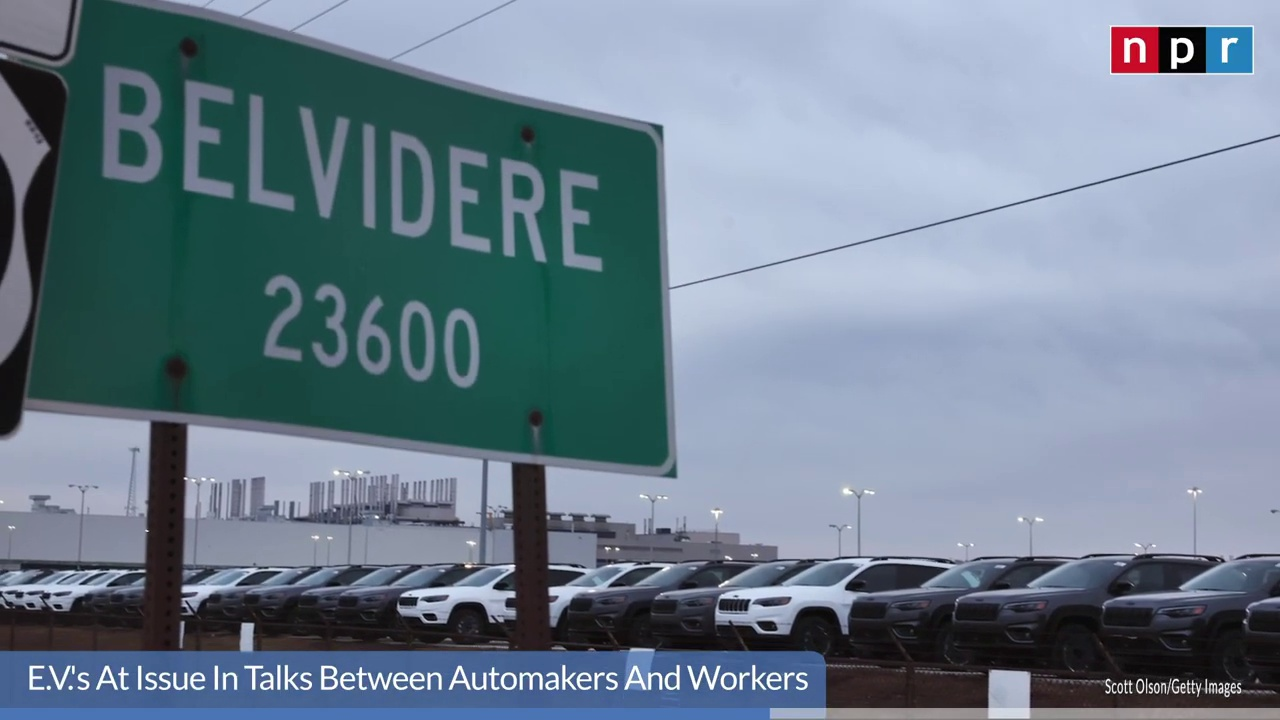

5. 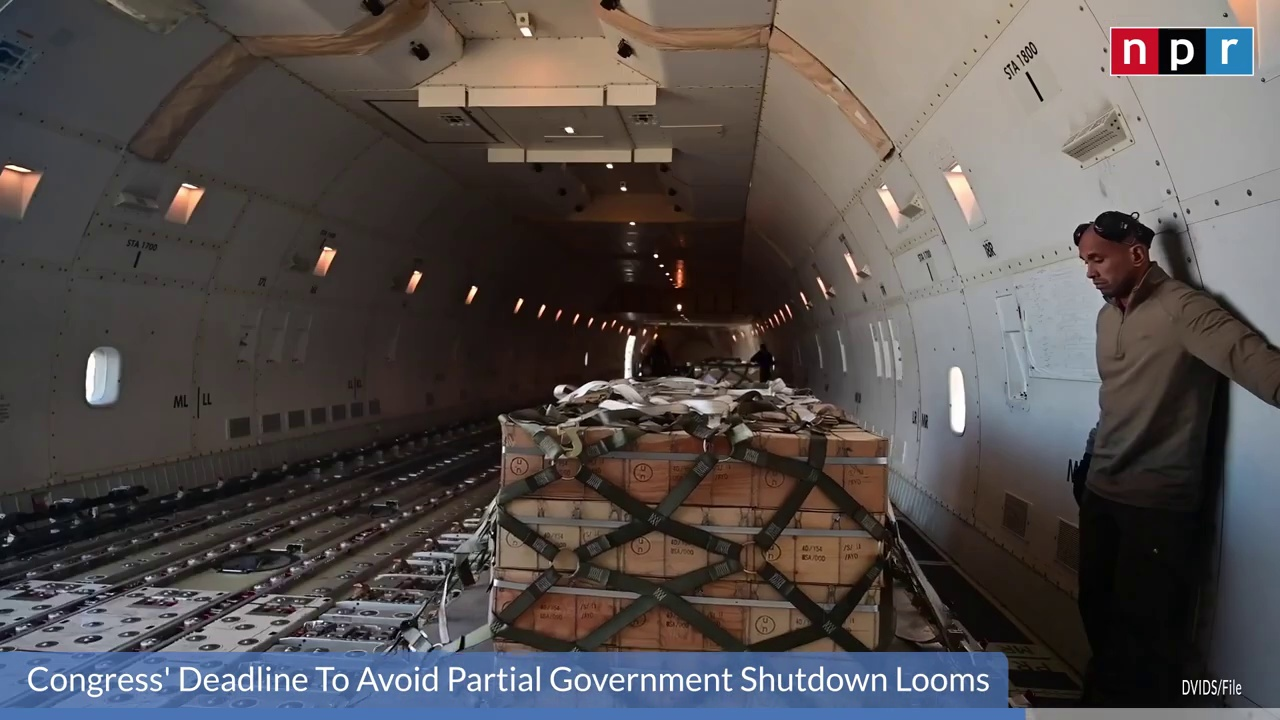

6. 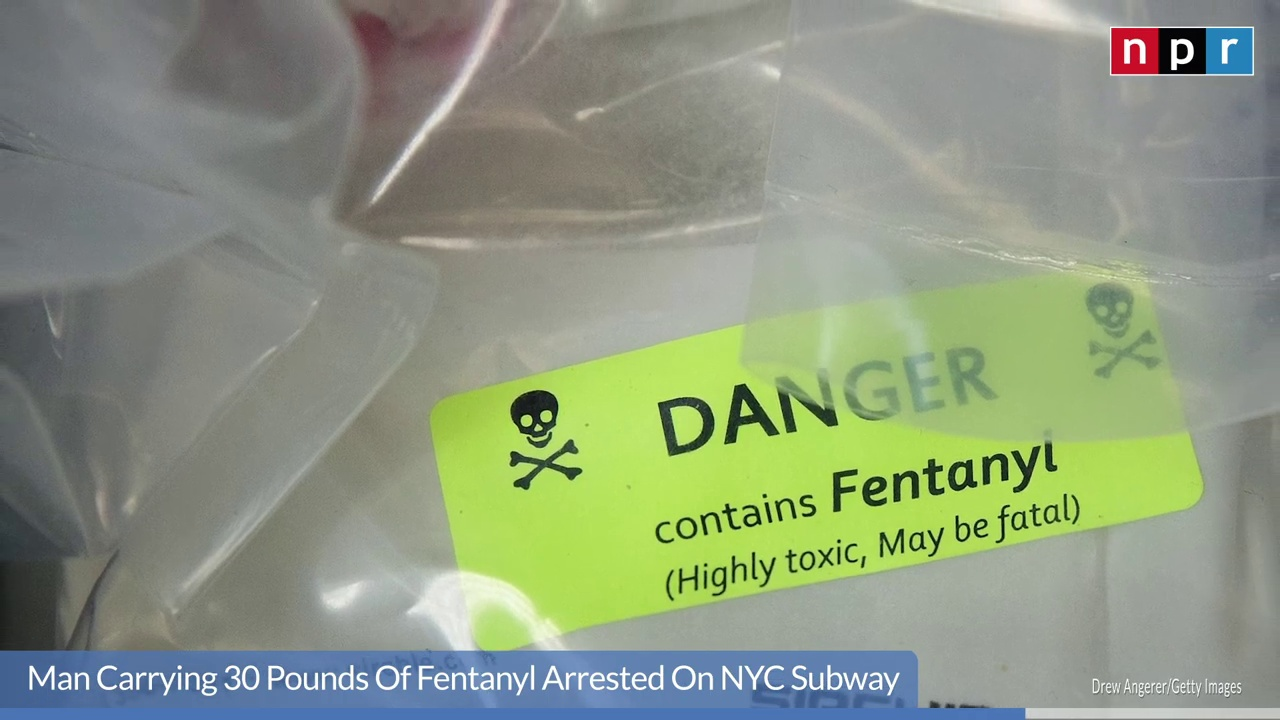

7. 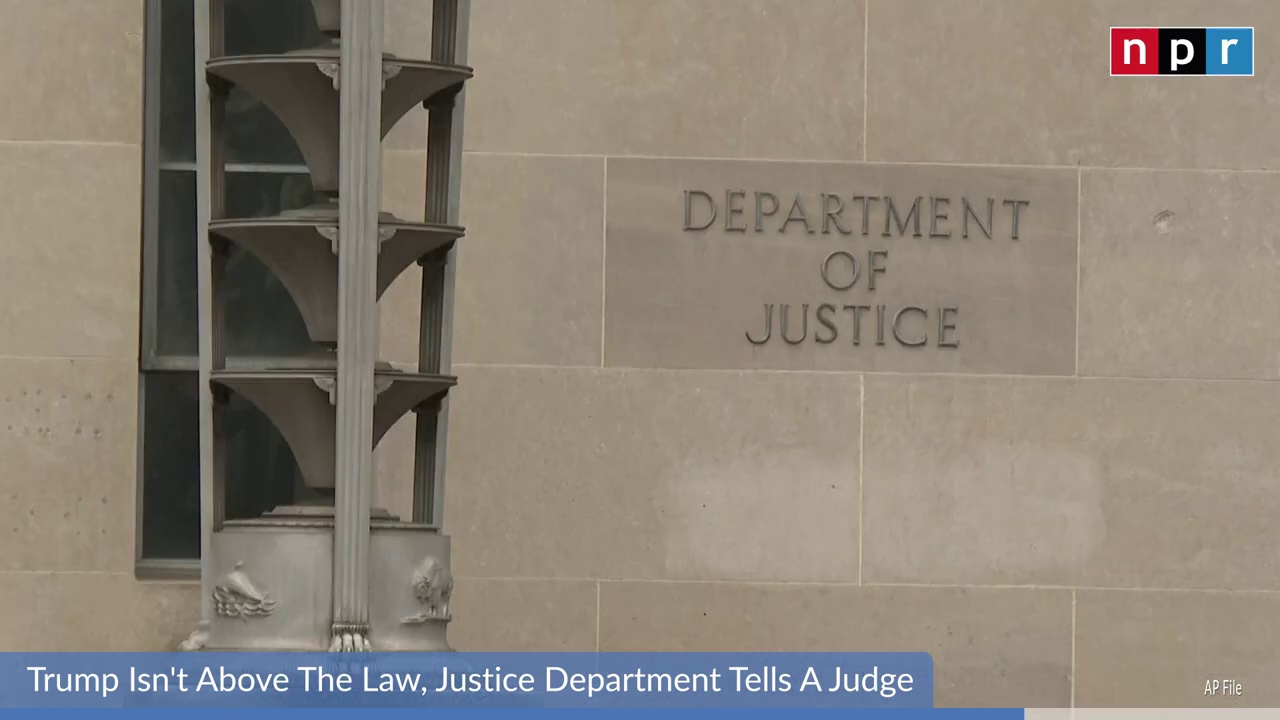

8. 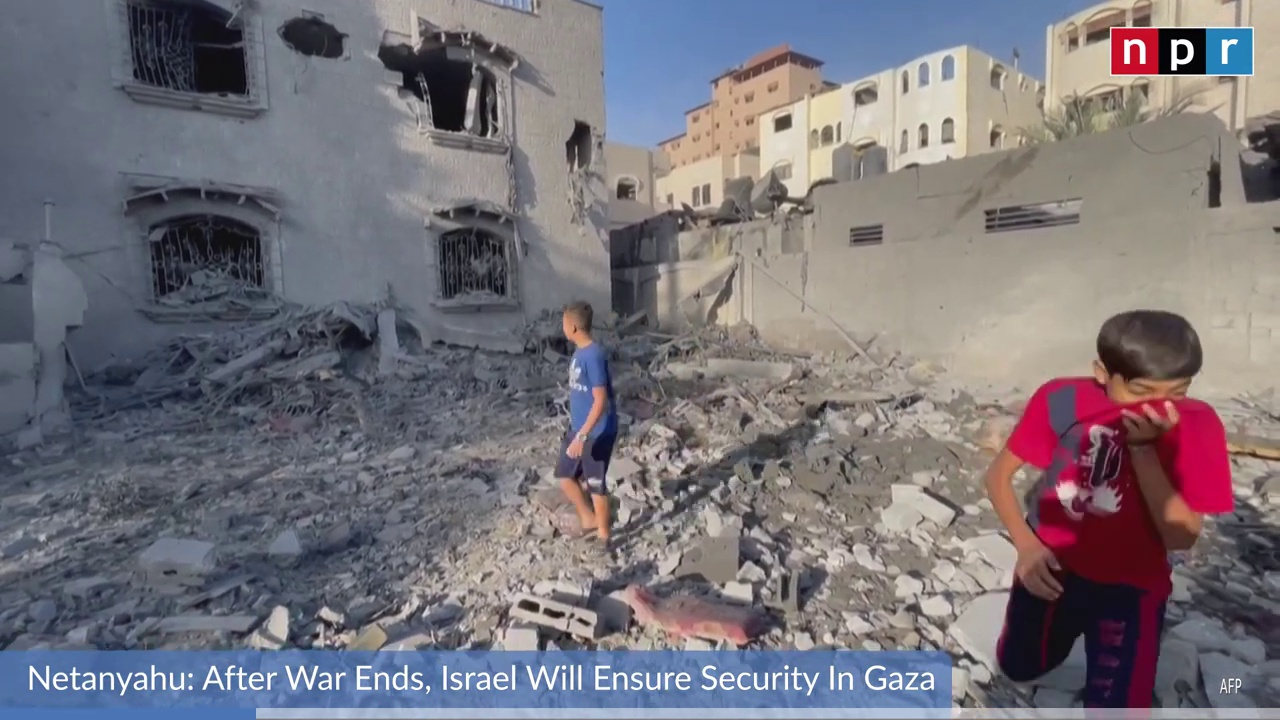

9. 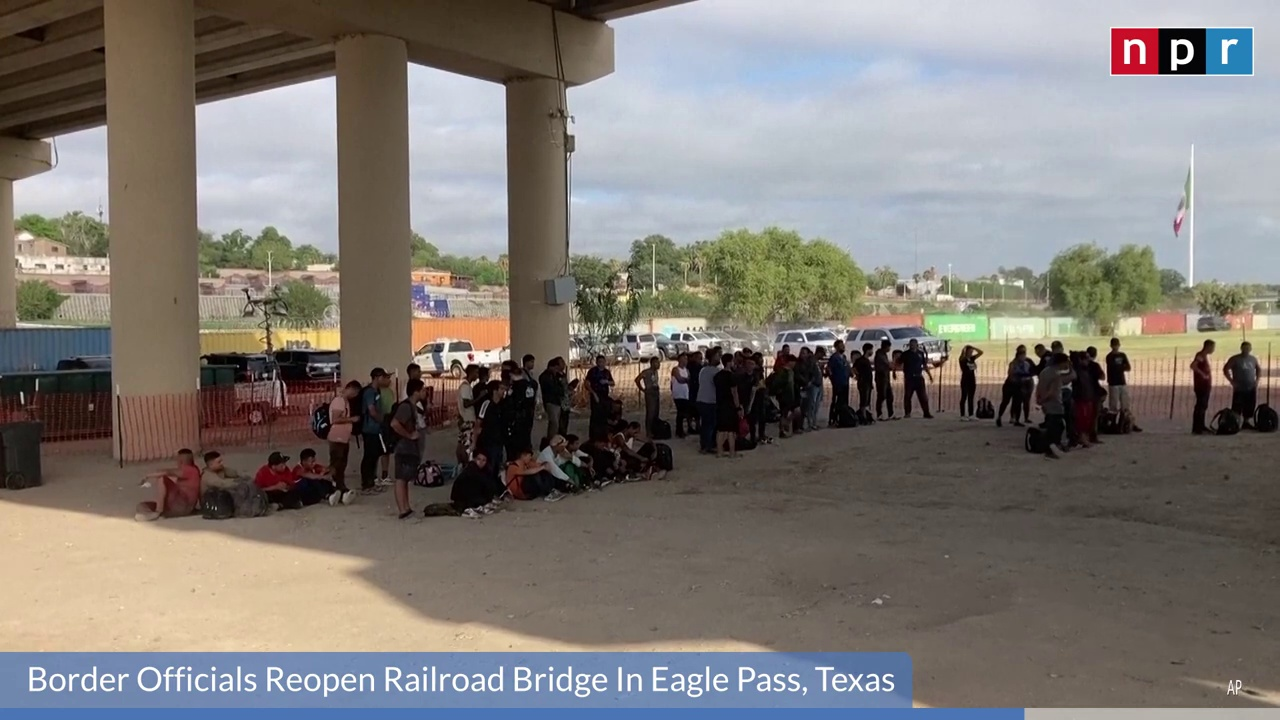

10. 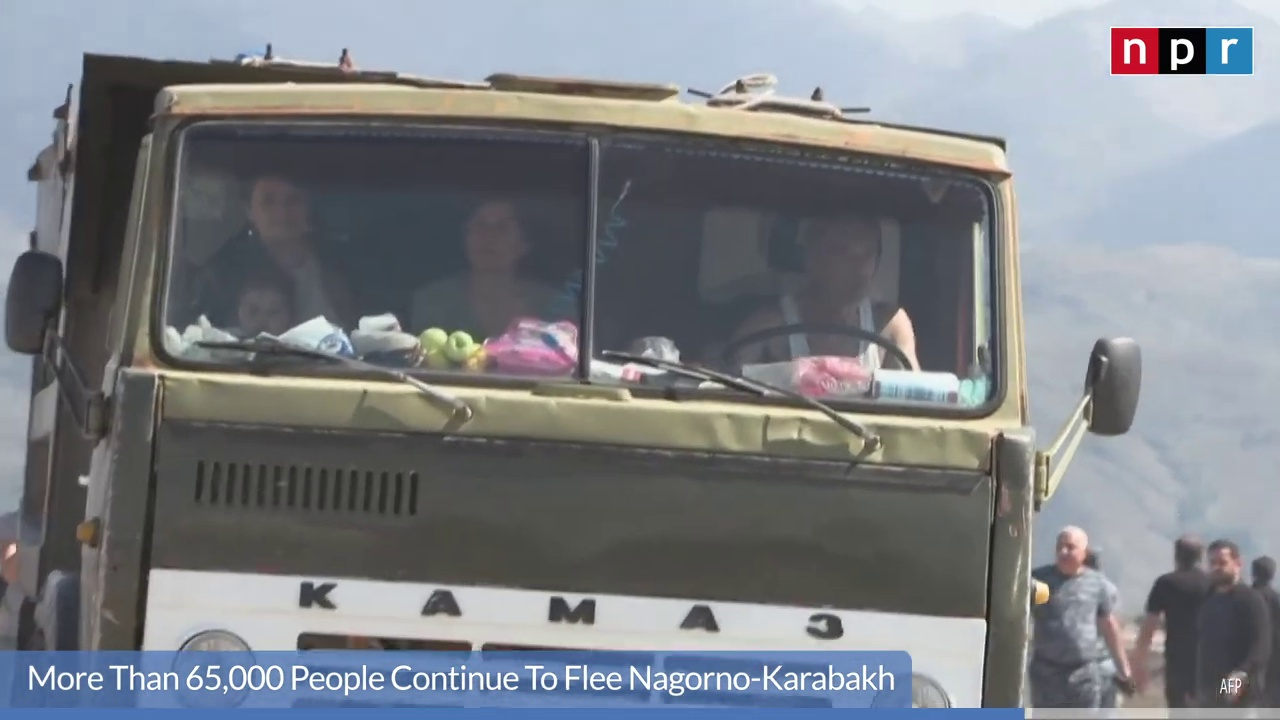